# 📊🔍 **Exploratory Data Analysis (EDA) Report** 📈📌  

In this section, we perform a detailed analysis of the dataset using **statistical methods** and **visualizations** to uncover patterns, trends, and insights.

In [2]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### 🔍 Loading & Inspecting the Dataset  

We begin by loading the dataset.

In [4]:
# Load the dataset
df = pd.read_csv("../data/dataset.csv", encoding="ISO-8859-1", low_memory=False)

### 📋 Dataset Overview  

This gives an overview of the dataset, including column names, data types, and missing values.

In [5]:

# Display basic info
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null

### 🔄 Handling Missing Values  
To ensure data consistency, missing values are handled using **forward fill (ffill)**, which propagates the last valid observation forward. This helps maintain continuity in time-series data.

In [7]:
# Handling missing values (example: forward fill, drop columns with too many NaNs)
df.fillna(method='ffill', inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_1808\547248588.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [8]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

### 📅 Breaking Down the Date  

We pull out important details from the date column to help understand how air quality changes over time:  

- **Year** – Helps see long-term pollution trends.  
- **Month** – Shows if certain seasons have worse air quality.  
- **Day** – Captures daily changes in pollution levels.  
- **Day of the Week** – Helps check if pollution is different on weekdays vs. weekends.

In [10]:
# Extract year, month, and day for temporal analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()

### 📊 AQI Calculation Method  

The following function calculates the **Air Quality Index (AQI)** based on major pollutants using **Central Pollution Control Board (CPCB) breakpoints**.  

#### 🛠️ Methodology:  
- The function takes a row of pollutant data as input.  
- It checks pollutant concentrations against predefined **breakpoints** (ranges for different AQI levels).  
- The **sub-index** for each pollutant is calculated using linear interpolation.  
- The **maximum sub-index** among all pollutants is taken as the final AQI.  

In [12]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
df['AQI'] =df.apply(calculate_aqi, axis=1)

### 📈 Tracking AQI Over the Years  

The graph displays how **average AQI** has changed over time:  

- **X-axis (Years)** → Represents different years in the dataset.  
- **Y-axis (AQI Values)** → Shows the average air quality index for each year.  
- **Title: "Average AQI Over the Years"** → Indicates the overall trend in air pollution levels.

C:\Users\hp\AppData\Local\Temp\ipykernel_1808\2783470769.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='year', y='AQI', data=df, estimator='mean', ci=None)


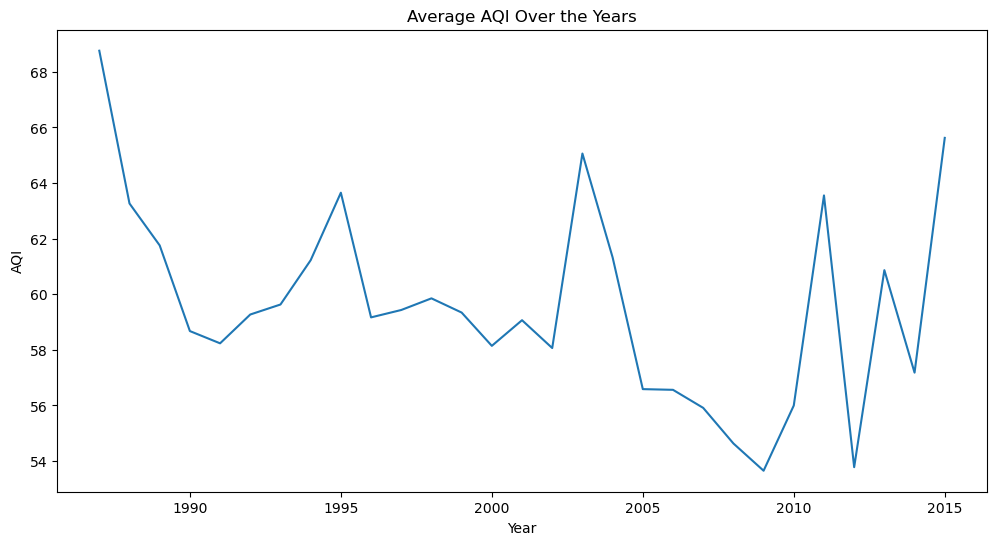

In [14]:
# --- 1. AQI Trends Over Time ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='AQI', data=df, estimator='mean', ci=None)
plt.title('Average AQI Over the Years')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.show()

### 📊 Understanding AQI Distribution  

This plot helps us see how AQI values are spread out:  

- **X-axis (AQI Values)** → Represents different AQI levels recorded.  
- **Y-axis (Frequency)** → Shows how often each AQI value appears in the dataset.  
- **Histogram + KDE** → The bars show actual counts, while the smooth curve helps visualize the overall distribution trend.

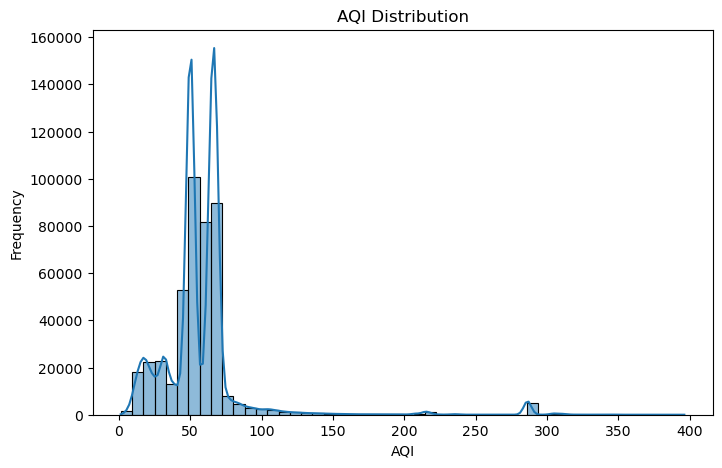

In [15]:
# --- 2. AQI Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df['AQI'].dropna(), bins=50, kde=True)
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


### 📊 Exploring Feature Relationships with a Heatmap  

This heatmap visually represents how different pollutants and AQI are connected:  

- **📈 Calculates Correlation** → Shows how strongly pollutants impact AQI.  
- **🎨 Color Scale** →  
  - **🔴 Red (Warm Colors)** → Strong positive correlation (both values increase together).  
  - **🔵 Blue (Cool Colors)** → Negative correlation (one value increases while the other decreases).  
- **🔢 Displayed Values** → Numbers indicate the exact correlation strength for better insights.

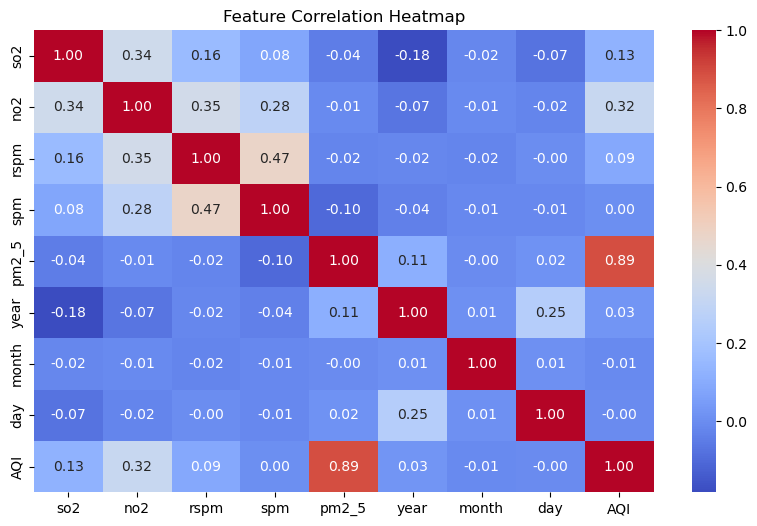

In [22]:
# --- 3. Correlation Between Pollutants ---
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



### 📦 Monthly AQI Variation  

This boxplot helps us understand how AQI levels fluctuate across different months:  

- **📆 X-Axis (Months)** → Represents each month from January to December.  
- **📊 Y-Axis (AQI Values)** → Displays the range of AQI values recorded in each month.  
- **📍 Median Line** → The bold line inside each box shows the median AQI for that month.  
- **📉 Box & Whiskers** → Represent the spread of AQI values, helping identify variations.  
- **⚠️ Outliers** → Dots outside the box indicate unusually high or low AQI values for that month.

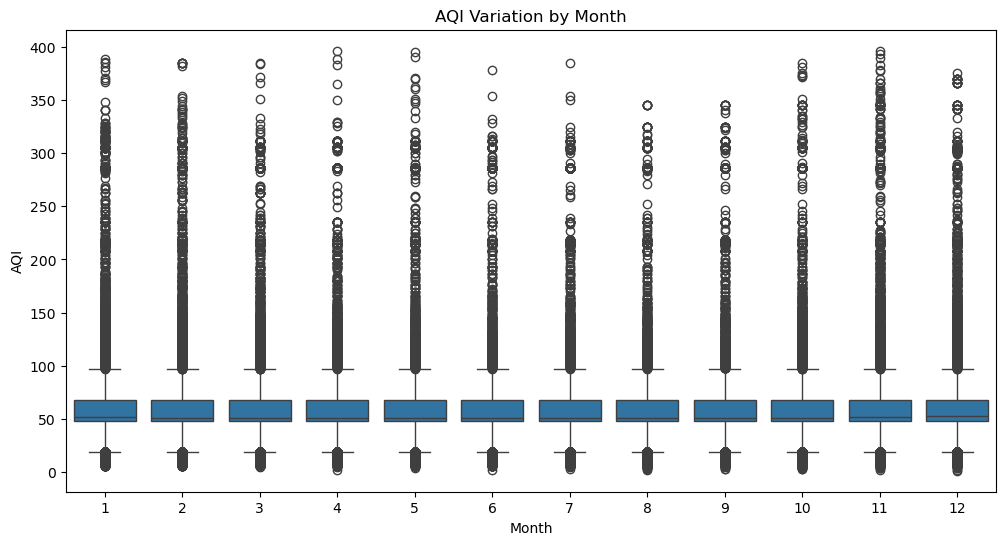

In [17]:
# --- 4. Boxplot of AQI by Month ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AQI', data=df)
plt.title('AQI Variation by Month')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.show()

### 🚨 Detecting Extreme Pollution Events  

This code identifies instances where **AQI exceeds 300**, indicating **severe pollution**:  

- **📅 Date** → Shows when the extreme pollution event occurred.  
- **📍 Location** → Displays the place where high AQI was recorded.  
- **🌫️ AQI Value** → Highlights the exact AQI level, signaling hazardous air quality.  

By analyzing these events, we can determine **patterns** and **potential causes** of extreme pollution.

In [ ]:
# --- 5. Extreme AQI Events ---
threshold = 300  # Define extreme pollution threshold
extreme_events = df[df['AQI'] > threshold]
print("Extreme Pollution Events:")
print(extreme_events[['date', 'location', 'AQI']])

Extreme Pollution Events:
             date   location         AQI
14095  2011-11-22  Hyderabad  345.841176
73673  2015-01-27      Delhi  320.186047
73700  2015-06-08      Delhi  304.837209
73730  2015-10-20      Delhi  326.325581
73731  2015-10-26      Delhi  329.395349
...           ...        ...         ...
435329 2015-01-24    Kolkata  309.441860
435330 2015-01-27    Kolkata  314.046512
435412 2015-11-10    Kolkata  324.790698
435413 2015-11-11    Kolkata  382.348837
435424 2015-12-21    Kolkata  301.000000

[971 rows x 3 columns]


### 🌆 Top 10 Most Polluted Cities  

This code calculates the **average AQI** for each city and ranks them from the most to least polluted:  

- **📊 Average AQI** → Measures long-term air quality in each city.  
- **🏙️ City Ranking** → Identifies the top 10 cities with the worst air pollution.  
- **⚠️ Impact** → Helps highlight areas that need urgent pollution control measures.  

This analysis provides insights into **which cities face the highest air pollution levels** over time.

In [19]:
# --- 6. Most Polluted Cities ---
city_avg_aqi = df.groupby('location')['AQI'].mean().sort_values(ascending=False)
print("Most Polluted Cities:")
print(city_avg_aqi.head(10))

Most Polluted Cities:
location
Panaji      286.344828
Panjim      286.344828
Vasco       286.344828
Mormugao    286.344828
MALDAH      218.068966
SILIGURI    218.068966
ULUBERIA    218.068966
DANKUNI     214.655172
Kalyani     214.655172
HALDIA      214.655172
Name: AQI, dtype: float64


### 🎆 Impact of Diwali on Air Quality  

This code **analyzes how AQI changes before and after Diwali** from 2004 to 2015:  

- 📅 **Pre-Diwali vs. Post-Diwali AQI** → Tracks pollution levels **7 days before** and **5 days after** Diwali each year.  
- 📈 **Line Graph Visualization** → Shows yearly trends in AQI changes due to Diwali celebrations.  
- ⚠️ **Pollution Spike Detection** → Helps understand how firecrackers and festival activities affect air quality.  
- ➖ **Dashed Line for Overall AQI** → Represents the **average AQI** across all years for comparison.  

This analysis helps determine whether **Diwali significantly increases air pollution** and how the trend has changed over the years.

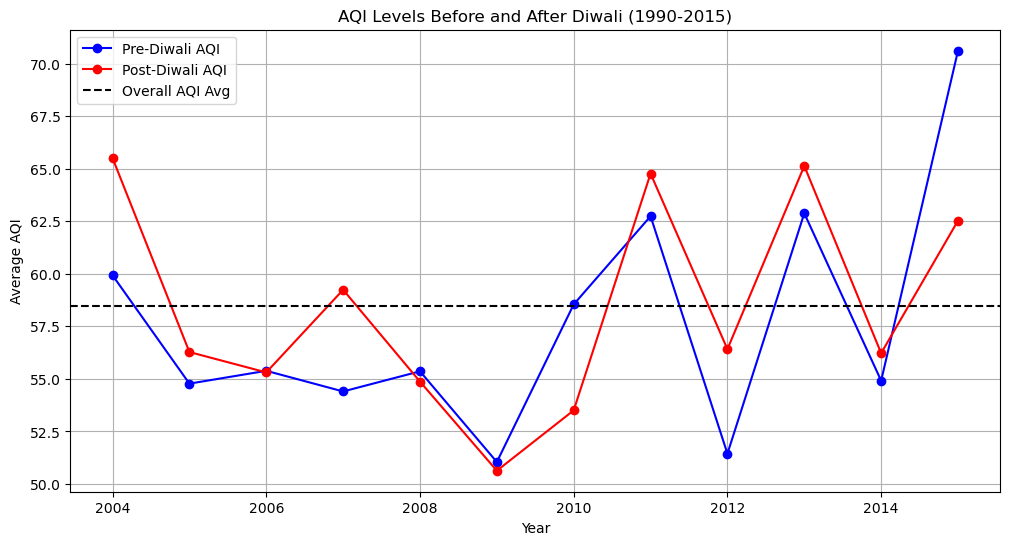

In [ ]:

# --- 7. AQI before and after diwali ---

diwali_dates = {
     2004: '2004-11-12', 2005: '2005-11-01',
    2006: '2006-10-21', 2007: '2007-11-09', 2008: '2008-10-28', 2009: '2009-10-17',
    2010: '2010-11-05', 2011: '2011-10-26', 2012: '2012-11-13', 2013: '2013-11-03',
    2014: '2014-10-23', 2015: '2015-11-11'
}


df['date'] = pd.to_datetime(df['date'])

# Store AQI trends
years = []
pre_diwali_aqi = []
post_diwali_aqi = []

for year, date in diwali_dates.items():
    diwali_date = pd.to_datetime(date)
    
    # Get AQI values 7 days before and after Diwali
    pre_diwali = df[(df['date'] >= diwali_date - pd.Timedelta(days=7)) & (df['date'] < diwali_date)]
    post_diwali = df[(df['date'] > diwali_date) & (df['date'] <= diwali_date + pd.Timedelta(days=5))]
    
    # Append results
    years.append(year)
    pre_diwali_aqi.append(pre_diwali['AQI'].mean())
    post_diwali_aqi.append(post_diwali['AQI'].mean())

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(years, pre_diwali_aqi, marker='o', label='Pre-Diwali AQI', color='blue')
plt.plot(years, post_diwali_aqi, marker='o', label='Post-Diwali AQI', color='red')
plt.axhline(y=df['AQI'].mean(), linestyle='dashed', color='black', label='Overall AQI Avg')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.title("AQI Levels Before and After Diwali (1990-2015)")
plt.legend()
plt.grid(True)
plt.show()


### 📆 Monthly AQI Trends Over the Years  

This code **visualizes how AQI changes each month** across multiple years:  

- 📊 **Month-by-Month AQI Trends** → Tracks how pollution fluctuates **from January to December** each year.  
- 🌈 **Colored Lines for Each Year** → Makes it easy to compare AQI variations across different years.  
- 🔎 **Legend for Year Identification** → Helps distinguish AQI trends for each year.  
- 🎨 **Clear Styling & Labels** → Ensures readability with proper titles, axis labels, and an optimized layout.  

This visualization helps identify **seasonal pollution trends**, such as **higher AQI in winter months** or any consistent patterns over time.

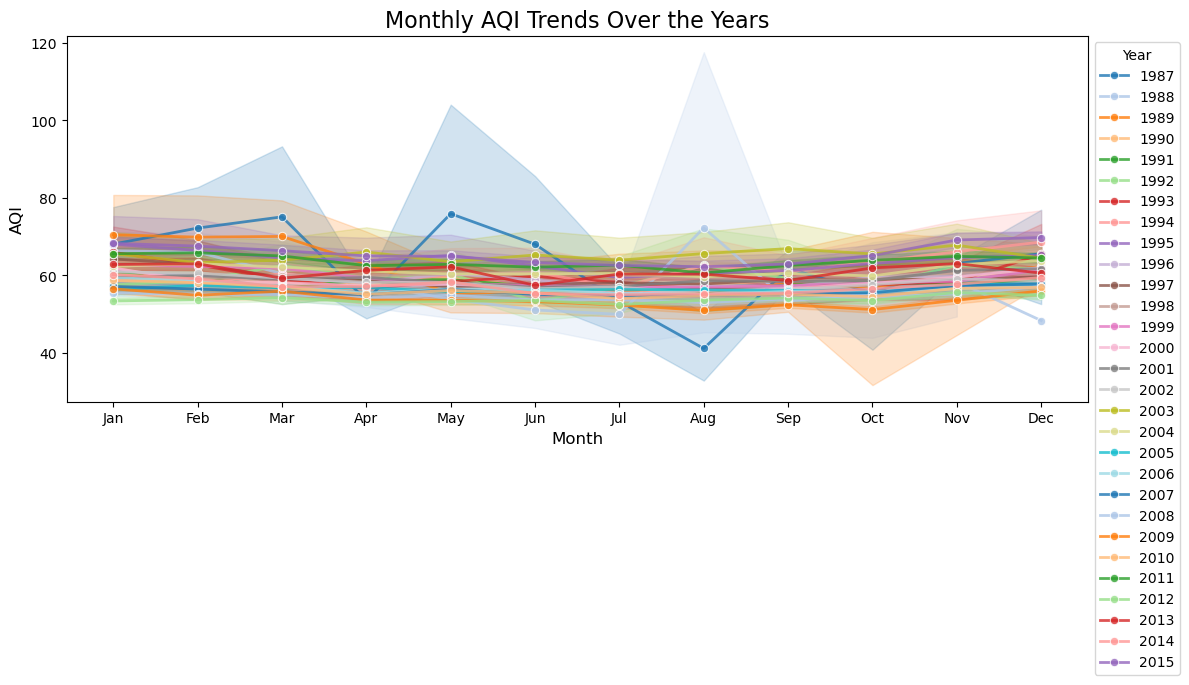

In [ ]:

# --- 8. Monthly AQI trends over the years ---

plt.figure(figsize=(12, 6))

sns.lineplot(x='month', y='AQI', hue='year', data=df, marker='o', lw=2, alpha=0.8, palette="tab20")

# Improve plot readability
plt.title("Monthly AQI Trends Over the Years", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("AQI", fontsize=12)
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])


plt.legend(title="Year", loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()
plt.show()


### 🌍 AQI Variation Across States  

This code **creates a boxplot to compare AQI levels** across different states:  

- 📦 **Boxplot Representation** → Each box shows the **AQI spread for a state**, with the middle line marking the **median AQI**.  
- 📍 **X-Axis: State Names** → Rotated labels improve readability for multiple states.  
- 📈 **Y-Axis: AQI Values** → Displays the range of AQI levels for each state.  
- 🔎 **Comparison of Air Quality** → Helps identify **highly polluted states** and those with **greater AQI variations**.  

This visualization makes it easy to see **which states experience worse air pollution** and where AQI levels fluctuate the most.

C:\Users\hp\AppData\Local\Temp\ipykernel_2616\1427081394.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='state', y='AQI', data=df, palette="Set2", width=0.7)


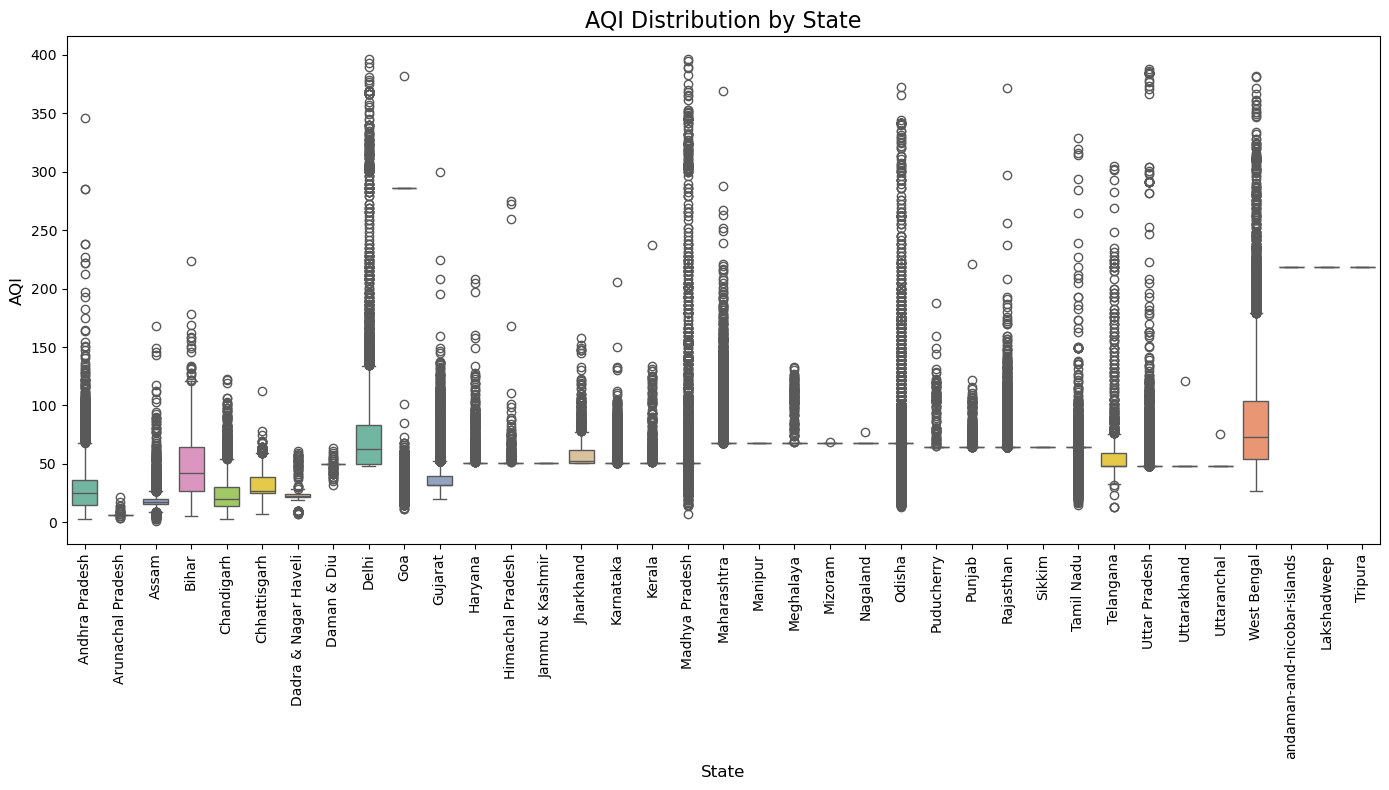

In [ ]:

# --- 9. AQI Distribution by State ---
plt.figure(figsize=(14, 8))
sns.boxplot(x='state', y='AQI', data=df, palette="Set2", width=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add titles and labels
plt.title("AQI Distribution by State", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("AQI", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### 🌫️ Extreme Pollution Events by Month  

This code **identifies and visualizes extreme pollution events** where AQI exceeds **300**:  

- 🔍 **Filtering Data** → Extracts only the cases where **AQI > 300** (severe pollution).  
- 📊 **Histogram Representation** → The x-axis shows **months (January to December)**, while the y-axis indicates **the number of extreme AQI events**.  
- 📈 **KDE Curve (Smooth Trendline)** → Helps visualize which **months experience more extreme pollution events** by smoothing out fluctuations.  

This visualization **highlights seasonal pollution trends**, showing when air quality tends to be at its worst.

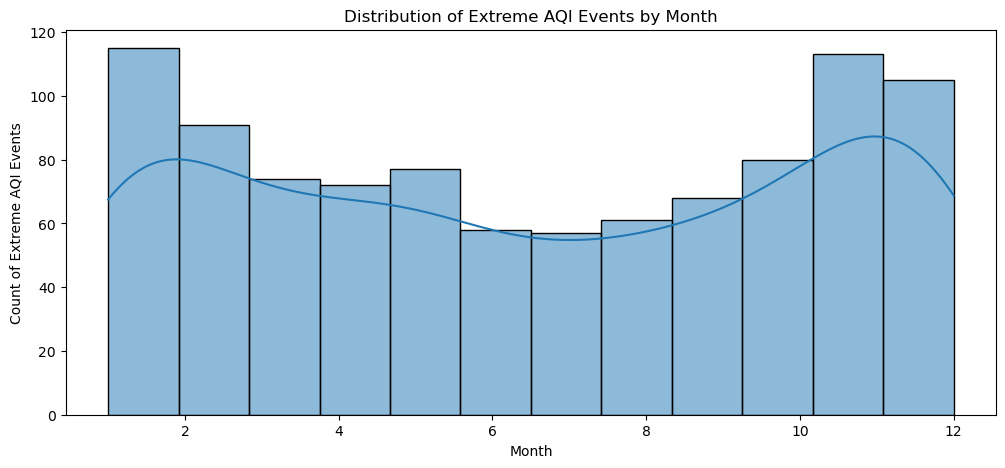

In [24]:
# --- 10. Distribution of Extreme AQI Events by Month ---

# Filter data to include only extreme AQI events (AQI > 300)
high_aqi = df[df['AQI'] > threshold]  # Defined threshold = 300 for extreme AQI

# Create the plot
plt.figure(figsize=(12, 5))
sns.histplot(high_aqi['month'], bins=12, kde=True)

# Add titles and labels
plt.title("Distribution of Extreme AQI Events by Month")
plt.xlabel("Month")
plt.ylabel("Count of Extreme AQI Events")

# Show the plot
plt.show()


### 📈 Yearly Average AQI Trend  

This code **calculates and visualizes the average AQI** for each year:  

- 🔢 **AQI Calculation** → Computes the **yearly average AQI** to track long-term trends.  
- 📊 **Line Graph Representation** →  
  - **X-axis** → Represents **years**.  
  - **Y-axis** → Shows the **yearly average AQI**.  
- 🔵 **Markers ('o')** → Highlight AQI values for each year, making trends clearer.  

This visualization **helps analyze whether air quality is improving or worsening over time** and can reveal long-term pollution patterns.

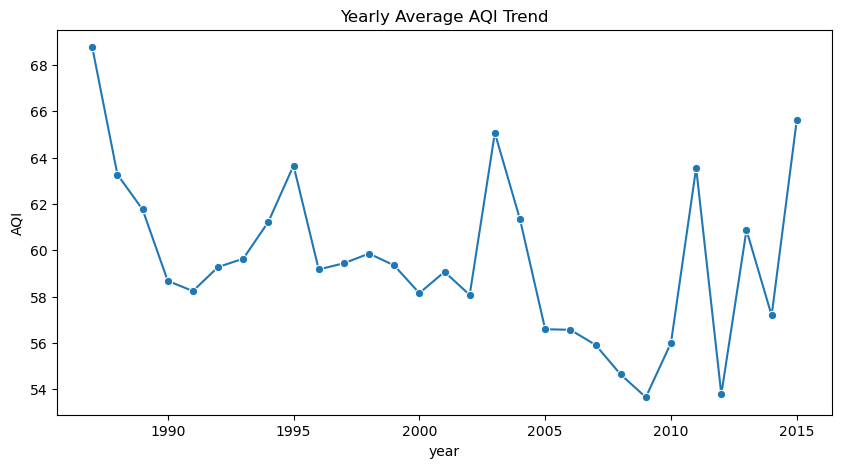

In [25]:
# --- 11. Yearly Average AQI Trend ---

# Group data by year and calculate the average AQI for each year
df_grouped = df.groupby('year')['AQI'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='AQI', data=df_grouped, marker='o')

# Add title
plt.title("Yearly Average AQI Trend")

# Show the plot
plt.show()




### 🌍 Top 10 Most Polluted States  

This code **analyzes and visualizes the states with the worst air quality**:  

- 📊 **AQI Calculation & Sorting** → Computes the **average AQI for each state** and sorts them from highest to lowest.  
- 🔟 **Top 10 Selection** → Focuses on the **10 most polluted states**.  
- 📉 **Bar Chart Representation** →  
  - **X-axis** → Lists the **states** (sorted by AQI).  
  - **Y-axis** → Shows the **average AQI levels**.  
- 📌 **Bar Heights** → Indicate **how severe air pollution is in each state**.  

This visualization **highlights the states with the worst air quality**, helping to pinpoint areas needing urgent pollution control measures.

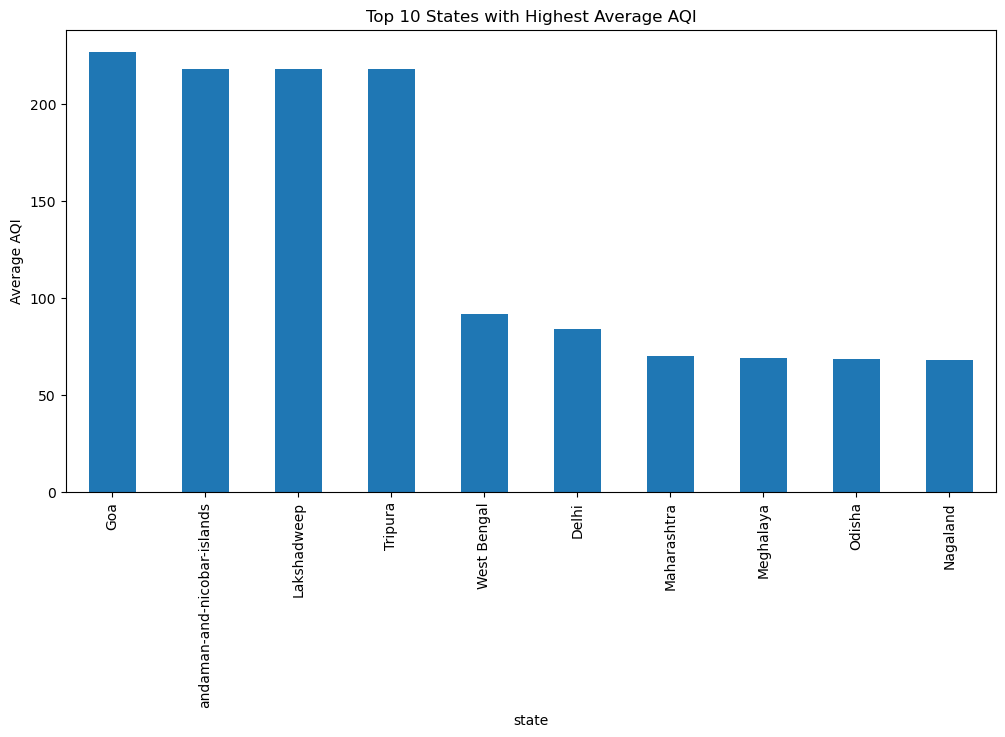

In [26]:
# --- 12. Top 10 States with Highest Average AQI ---

plt.figure(figsize=(12, 6))

# Calculate the average AQI for each state, sort in descending order, and select the top 10
df.groupby('state')['AQI'].mean().sort_values(ascending=False).head(10).plot(kind='bar')

# Add title and labels
plt.title('Top 10 States with Highest Average AQI')
plt.ylabel('Average AQI')

# Show the plot
plt.show()


### 📦 AQI Distribution Boxplot  

This code **visualizes the spread of AQI (Air Quality Index) values** using a **boxplot**:  

- 📊 **Box Representation** → Shows the **middle 50%** of AQI values.  
- 📉 **Median Line** → The line inside the box represents the **median AQI**.  
- ➖ **Whiskers** → Extend to cover the **majority of AQI values**.  
- ⚠️ **Outliers (Dots)** → Represent **extreme pollution events** beyond the usual range.  

This visualization **helps understand AQI distribution**, identify pollution trends, and detect **unusually high AQI events**.

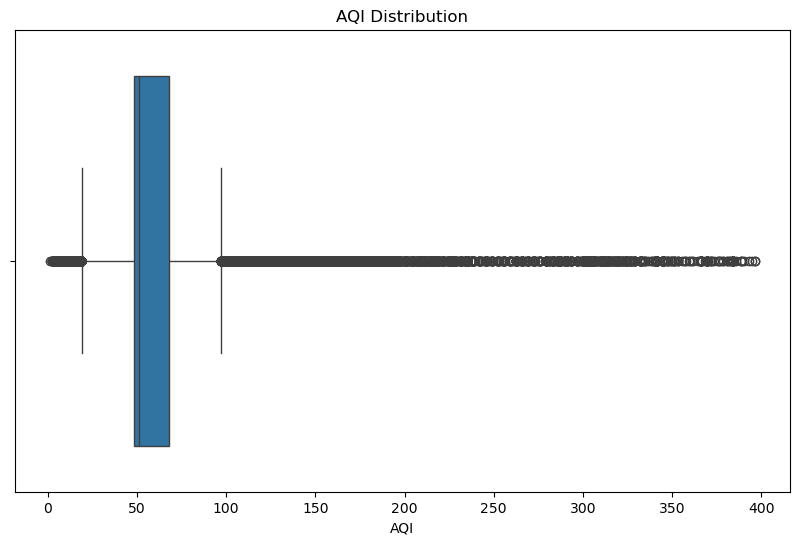

In [27]:
# --- 13. AQI Distribution (Boxplot) ---

plt.figure(figsize=(10, 6))

# Create a boxplot to show AQI distribution
sns.boxplot(x='AQI', data=df)

# Add title
plt.title('AQI Distribution')

# Show the plot
plt.show()
